# EDA 및 전처리

이 노트북에서는 다음을 수행합니다:
1. **실제 데이터** (train.csv) 로드 및 탐색
2. 정상성 테스트 (ADF, KPSS) 수행 및 시각화
3. STL 분해 수행 및 시각화
4. 비정상 시계열에 차분 적용

In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 프로젝트 루트를 경로에 추가
sys.path.insert(0, str(Path.cwd().parent))

# 모듈 reload (소스 코드 수정 후 반영을 위해)
import importlib
import src.preprocess
importlib.reload(src.preprocess)

from config import Config
from src.preprocess import (
    preprocess_pipeline,
    check_stationarity_all_items,
    decompose_all_items
)

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드

In [2]:
# 실제 데이터 로드
data_path = Config.DATA_RAW / "train.csv"

if not data_path.exists():
    print(f"⚠️ 데이터 파일이 없습니다: {data_path}")
    print("data/raw/ 폴더에 train.csv 파일을 업로드하세요.")
else:
    # 데이터 로드
    df = pd.read_csv(data_path)
    print(f"원본 데이터 shape: {df.shape}")
    print(f"컬럼: {list(df.columns)}")
    
    # 날짜 생성
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    
    # 월별 집계 (SUM)
    print("\n월별 집계 중...")
    df_agg = df.groupby(['date', 'item_id']).agg({
        'value': 'sum',
        'weight': 'sum',
        'quantity': 'sum'
    }).reset_index()
    
    # Wide 형식으로 피벗
    df_wide = df_agg.pivot(index='date', columns='item_id', values='value')
    
    print(f"\n✓ 전처리 완료!")
    print(f"  - 집계 후 shape: {df_agg.shape}")
    print(f"  - Wide 형식 shape: {df_wide.shape}")
    print(f"  - 날짜 범위: {df_wide.index.min().strftime('%Y-%m')} ~ {df_wide.index.max().strftime('%Y-%m')}")
    print(f"  - 품목 수: {len(df_wide.columns)}")
    print(f"  - 결측값: {df_wide.isnull().sum().sum()}개 ({df_wide.isnull().sum().sum() / df_wide.size * 100:.1f}%)")

원본 데이터 shape: (10836, 9)
컬럼: ['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity', 'value']

월별 집계 중...

✓ 전처리 완료!
  - 집계 후 shape: (3776, 5)
  - Wide 형식 shape: (43, 100)
  - 날짜 범위: 2022-01 ~ 2025-07
  - 품목 수: 100
  - 결측값: 524개 (12.2%)


In [3]:
# 데이터 미리보기
df_wide.head(10)

item_id,AANGBULD,AHMDUILJ,ANWUJOKX,APQGTRMF,ATLDMDBO,AXULOHBQ,BEZYMBBT,BJALXPFS,BLANHGYY,BSRMSVTC,...,XIFHSOWQ,XIIEJNEE,XIPPENFQ,XMKRPGLB,XUOIQPFL,YSYHGLQK,ZCELVYQU,ZGJXVMNI,ZKENOUDA,ZXERAXWP
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,14276.0,242705.0,NaN,383999.0,143097177.0,11429.0,6034752.0,352532.0,NaN,1216269.0,...,7718.0,NaN,108699.0,879207.0,10871069.0,NaN,373859.0,1154724.0,122627.0,10867.0
2022-02-01,52347.0,120847.0,NaN,512813.0,103568323.0,16365.0,6221091.0,218947.0,891.0,156005.0,...,24829.0,81.0,78853.0,1650028.0,9573079.0,543.0,59900.0,1337622.0,38162.0,675.0
2022-03-01,53549.0,197317.0,NaN,217064.0,118403737.0,47307.0,4611537.0,331472.0,NaN,801085.0,...,102019.0,3198210.0,172237.0,1831614.0,8774783.0,766.0,31158.0,1662893.0,3592.0,20548.0
2022-04-01,NaN,126142.0,63580.0,470398.0,121873741.0,59524.0,5202039.0,17480.0,NaN,365605.0,...,33215.0,NaN,89681.0,705567.0,4713153.0,1108.0,594407.0,1561647.0,5613.0,662.0
2022-05-01,26997.0,71730.0,81670.0,539873.0,115024617.0,74828.0,6889516.0,234330.0,23141.0,168725.0,...,82348.0,81175.0,81387.0,1718634.0,4612292.0,859.0,648232.0,1603223.0,33924.0,18949.0
2022-06-01,84489.0,149138.0,26424.0,582317.0,65716075.0,36182.0,5338460.0,51692.0,13258.0,948322.0,...,42138.0,144.0,164749.0,1884328.0,3603001.0,1426.0,496737.0,1641942.0,74939.0,4566.0
2022-07-01,NaN,186617.0,8470.0,759980.0,146216818.0,70404.0,6549792.0,164195.0,12467.0,276971.0,...,87886.0,NaN,166570.0,385689.0,6383064.0,2413.0,210179.0,1815161.0,93976.0,12358.0
2022-08-01,NaN,169995.0,NaN,216019.0,97552978.0,156481.0,4476319.0,59646.0,26514.0,159911.0,...,38781.0,NaN,129194.0,766922.0,5530462.0,638.0,NaN,1546959.0,83364.0,5108.0
2022-09-01,NaN,140547.0,NaN,537693.0,72341427.0,231421.0,5714072.0,201135.0,26512.0,547603.0,...,16369.0,650.0,127122.0,654225.0,4808943.0,NaN,70748.0,1536799.0,53842.0,7954.0


In [4]:
# 기본 통계
df_wide.describe()

item_id,AANGBULD,AHMDUILJ,ANWUJOKX,APQGTRMF,ATLDMDBO,AXULOHBQ,BEZYMBBT,BJALXPFS,BLANHGYY,BSRMSVTC,...,XIFHSOWQ,XIIEJNEE,XIPPENFQ,XMKRPGLB,XUOIQPFL,YSYHGLQK,ZCELVYQU,ZGJXVMNI,ZKENOUDA,ZXERAXWP
count,29.000000,43.000000,8.000000,42.000000,4.300000e+01,43.000000,4.300000e+01,43.000000,29.000000,4.300000e+01,...,4.300000e+01,2.800000e+01,43.000000,4.300000e+01,4.300000e+01,39.000000,4.000000e+01,4.300000e+01,43.000000,43.000000
mean,124577.965517,126828.813953,43788.625000,263332.142857,5.999737e+07,96264.093023,4.939373e+06,164484.279070,18665.137931,5.216824e+05,...,1.915444e+05,1.380925e+05,149003.302326,1.125717e+06,4.558579e+06,2457.384615,2.135008e+05,2.256273e+06,163893.837209,11297.418605
std,162567.648734,46050.152437,27555.179362,210758.645301,3.273012e+07,69500.527392,1.000393e+06,92195.307829,28389.806625,5.807090e+05,...,3.073484e+05,6.021119e+05,85825.006390,6.760341e+05,1.847358e+06,2635.161601,3.027898e+05,8.538016e+05,163688.460344,7753.158623
min,299.000000,29231.000000,8470.000000,77.000000,2.545041e+07,11429.000000,2.601088e+06,17480.000000,166.000000,6.196100e+04,...,7.718000e+03,3.700000e+01,40763.000000,2.436110e+05,2.060879e+06,173.000000,8.600000e+01,1.141931e+06,384.000000,662.000000
25%,26507.000000,89385.500000,27591.000000,118354.750000,3.303382e+07,48408.500000,4.419852e+06,99490.500000,4000.000000,2.233075e+05,...,4.171450e+04,8.075000e+01,92778.000000,4.729365e+05,3.455008e+06,685.500000,1.721075e+04,1.566712e+06,51536.000000,5939.000000
50%,41142.000000,126401.000000,30855.000000,210672.500000,5.066380e+07,71046.000000,4.867511e+06,147123.000000,7350.000000,4.181910e+05,...,6.424700e+04,5.985000e+02,127122.000000,8.792070e+05,3.955354e+06,1298.000000,7.283050e+04,1.816734e+06,93976.000000,9575.000000
75%,144248.000000,151083.500000,67803.750000,402502.250000,7.316830e+07,137064.500000,5.745086e+06,216447.500000,20404.000000,5.663370e+05,...,1.165170e+05,1.515700e+04,181755.000000,1.773725e+06,5.208298e+06,3090.500000,3.083422e+05,3.008946e+06,314234.500000,15702.500000
max,533478.000000,242705.000000,81670.000000,759980.000000,1.462168e+08,344263.000000,6.889516e+06,352827.000000,128334.000000,3.563685e+06,...,1.565087e+06,3.198210e+06,467479.000000,2.212506e+06,1.087107e+07,10651.000000,1.187539e+06,4.419464e+06,582914.000000,42690.000000


## 2. 시계열 시각화

일부 품목의 시계열 패턴을 시각화합니다.

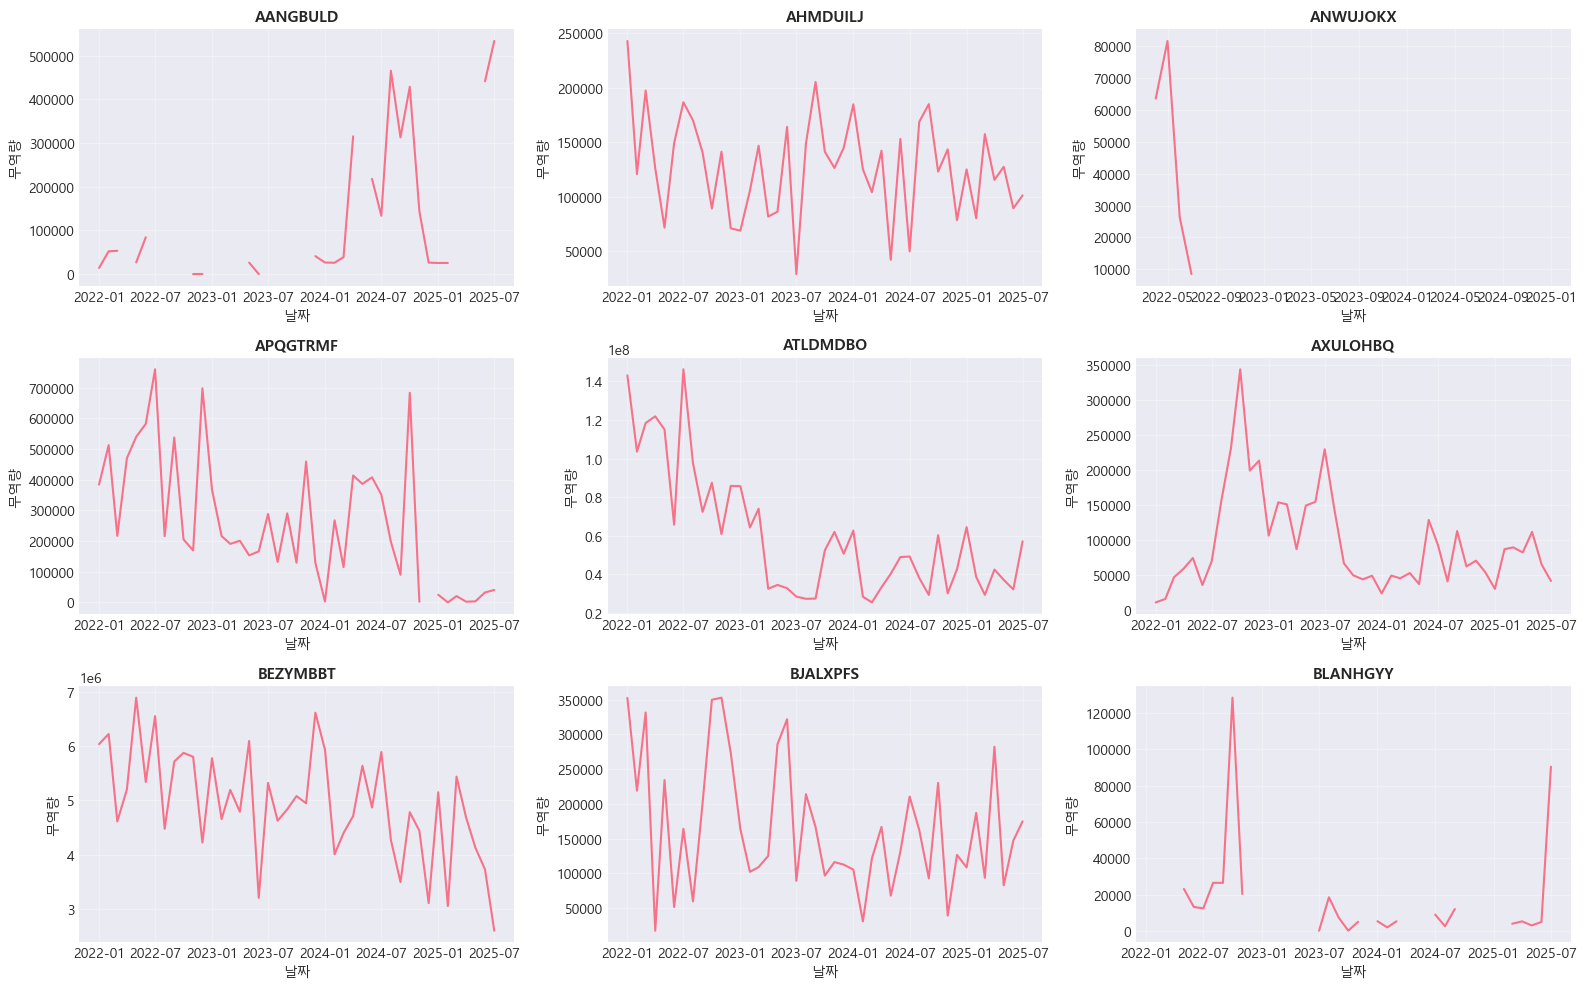

In [5]:
# 처음 9개 품목의 시계열 플롯
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(df_wide.columns[:9]):
    axes[i].plot(df_wide.index, df_wide[col], linewidth=1.5)
    axes[i].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('날짜')
    axes[i].set_ylabel('무역량')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 정상성 테스트 (ADF & KPSS)

모든 품목에 대해 ADF와 KPSS 검정을 수행합니다.

In [6]:
# 정상성 테스트 수행
stationarity_results = check_stationarity_all_items(df_wide, significance_level=0.05)

# 결과 미리보기
print("\n정상성 테스트 결과 (처음 10개):")
stationarity_results.head(10)

INFO:src.preprocess:정상성 테스트 수행 중 (100개 품목)...
c:\Users\SMART\git\daconai\src\preprocess.py:366: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series_clean, regression=regression, nlags='auto')
c:\Users\SMART\git\daconai\src\preprocess.py:366: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series_clean, regression=regression, nlags='auto')
c:\Users\SMART\git\daconai\src\preprocess.py:366: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series_clean, regression=regression, nlags='auto')
c:\Users\SMART\git\daconai\src\preprocess.py:366: InterpolationWarning: The test statistic is outside 


정상성 테스트 결과 (처음 10개):


,item_code,adf_statistic,adf_p_value,adf_is_stationary,kpss_statistic,kpss_p_value,kpss_is_stationary,both_stationary
0,AANGBULD,-1.763057,3.989510e-01,False,0.516781,0.037887,False,False
1,AHMDUILJ,-7.384366,8.311502e-11,True,0.211423,0.100000,True,True
2,ANWUJOKX,NaN,1.000000e+00,False,NaN,0.000000,False,False
3,APQGTRMF,-4.505771,1.919718e-04,True,0.675969,0.015730,False,False
4,ATLDMDBO,-2.613940,9.015018e-02,False,0.697560,0.013767,False,False
5,AXULOHBQ,-2.462635,1.248323e-01,False,0.241698,0.100000,True,False
6,BEZYMBBT,-5.404117,3.320413e-06,True,0.886334,0.010000,False,False
7,BJALXPFS,-6.005775,1.616896e-07,True,0.357146,0.095627,True,True
8,BLANHGYY,-3.919915,1.893078e-03,True,0.221346,0.100000,True,True
9,BSRMSVTC,-7.098434,4.229294e-10,True,0.399113,0.077538,True,True


In [7]:
# 결과 요약
summary = {
    'ADF 정상성': stationarity_results['adf_is_stationary'].sum(),
    'KPSS 정상성': stationarity_results['kpss_is_stationary'].sum(),
    '양쪽 모두 정상성': stationarity_results['both_stationary'].sum(),
    '총 품목 수': len(stationarity_results)
}

print("\n" + "=" * 50)
print("정상성 테스트 요약")
print("=" * 50)
for key, value in summary.items():
    if key != '총 품목 수':
        pct = value / summary['총 품목 수'] * 100
        print(f"{key}: {value}개 ({pct:.1f}%)")
    else:
        print(f"{key}: {value}개")
print("=" * 50)


정상성 테스트 요약
ADF 정상성: 70개 (70.0%)
KPSS 정상성: 60개 (60.0%)
양쪽 모두 정상성: 52개 (52.0%)
총 품목 수: 100개


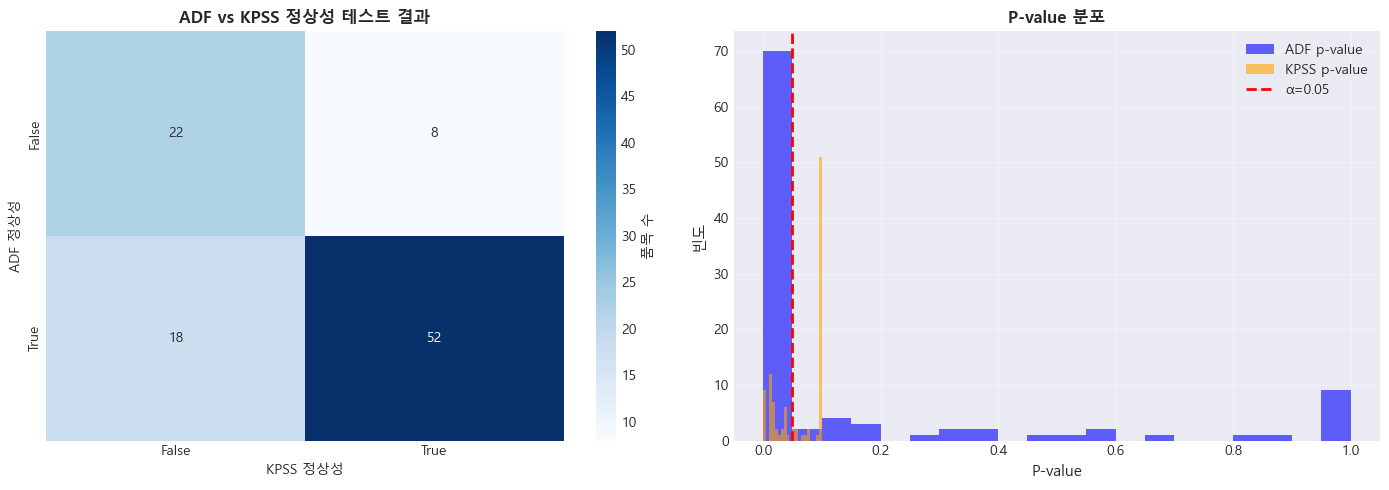

In [8]:
# 정상성 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ADF vs KPSS
crosstab = pd.crosstab(stationarity_results['adf_is_stationary'], 
                       stationarity_results['kpss_is_stationary'],
                       rownames=['ADF 정상성'],
                       colnames=['KPSS 정상성'])

sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': '품목 수'})
axes[0].set_title('ADF vs KPSS 정상성 테스트 결과', fontsize=12, fontweight='bold')

# P-value 분포
axes[1].hist(stationarity_results['adf_p_value'].dropna(), bins=20, alpha=0.6, label='ADF p-value', color='blue')
axes[1].hist(stationarity_results['kpss_p_value'].dropna(), bins=20, alpha=0.6, label='KPSS p-value', color='orange')
axes[1].axvline(0.05, color='red', linestyle='--', linewidth=2, label='α=0.05')
axes[1].set_xlabel('P-value', fontsize=11)
axes[1].set_ylabel('빈도', fontsize=11)
axes[1].set_title('P-value 분포', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# 비정상 품목 확인
non_stationary_items = stationarity_results[~stationarity_results['both_stationary']]['item_code'].tolist()

print(f"\n비정상 품목 수: {len(non_stationary_items)}개")
if len(non_stationary_items) > 0:
    print("\n비정상 품목 목록 (처음 20개):")
    print(non_stationary_items[:20])


비정상 품목 수: 48개

비정상 품목 목록 (처음 20개):
['AANGBULD', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BTMOEMEP', 'DBWLZWNK', 'DEWLVASR', 'DNMPSKTB', 'ELQGMQWE', 'EVBVXETX', 'FDXPMYGF', 'GIKPEWTY', 'GMBFCMIU', 'GYHKIVQT', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JPBRUTWP']


## 4. STL 분해 (Seasonal-Trend-Loess)

시계열을 추세, 계절성, 잔차로 분해합니다.

In [10]:
# STL 분해 수행
decomposition_results = decompose_all_items(df_wide, period=12, seasonal=7)

df_trend = decomposition_results['trend']
df_seasonal = decomposition_results['seasonal']
df_resid = decomposition_results['resid']

print(f"\nTrend shape: {df_trend.shape}")
print(f"Seasonal shape: {df_seasonal.shape}")
print(f"Residual shape: {df_resid.shape}")

INFO:src.preprocess:STL 분해 수행 중 (100개 품목)...
INFO:src.preprocess:✓ STL 분해 완료: 100개 품목



Trend shape: (43, 100)
Seasonal shape: (43, 100)
Residual shape: (43, 100)


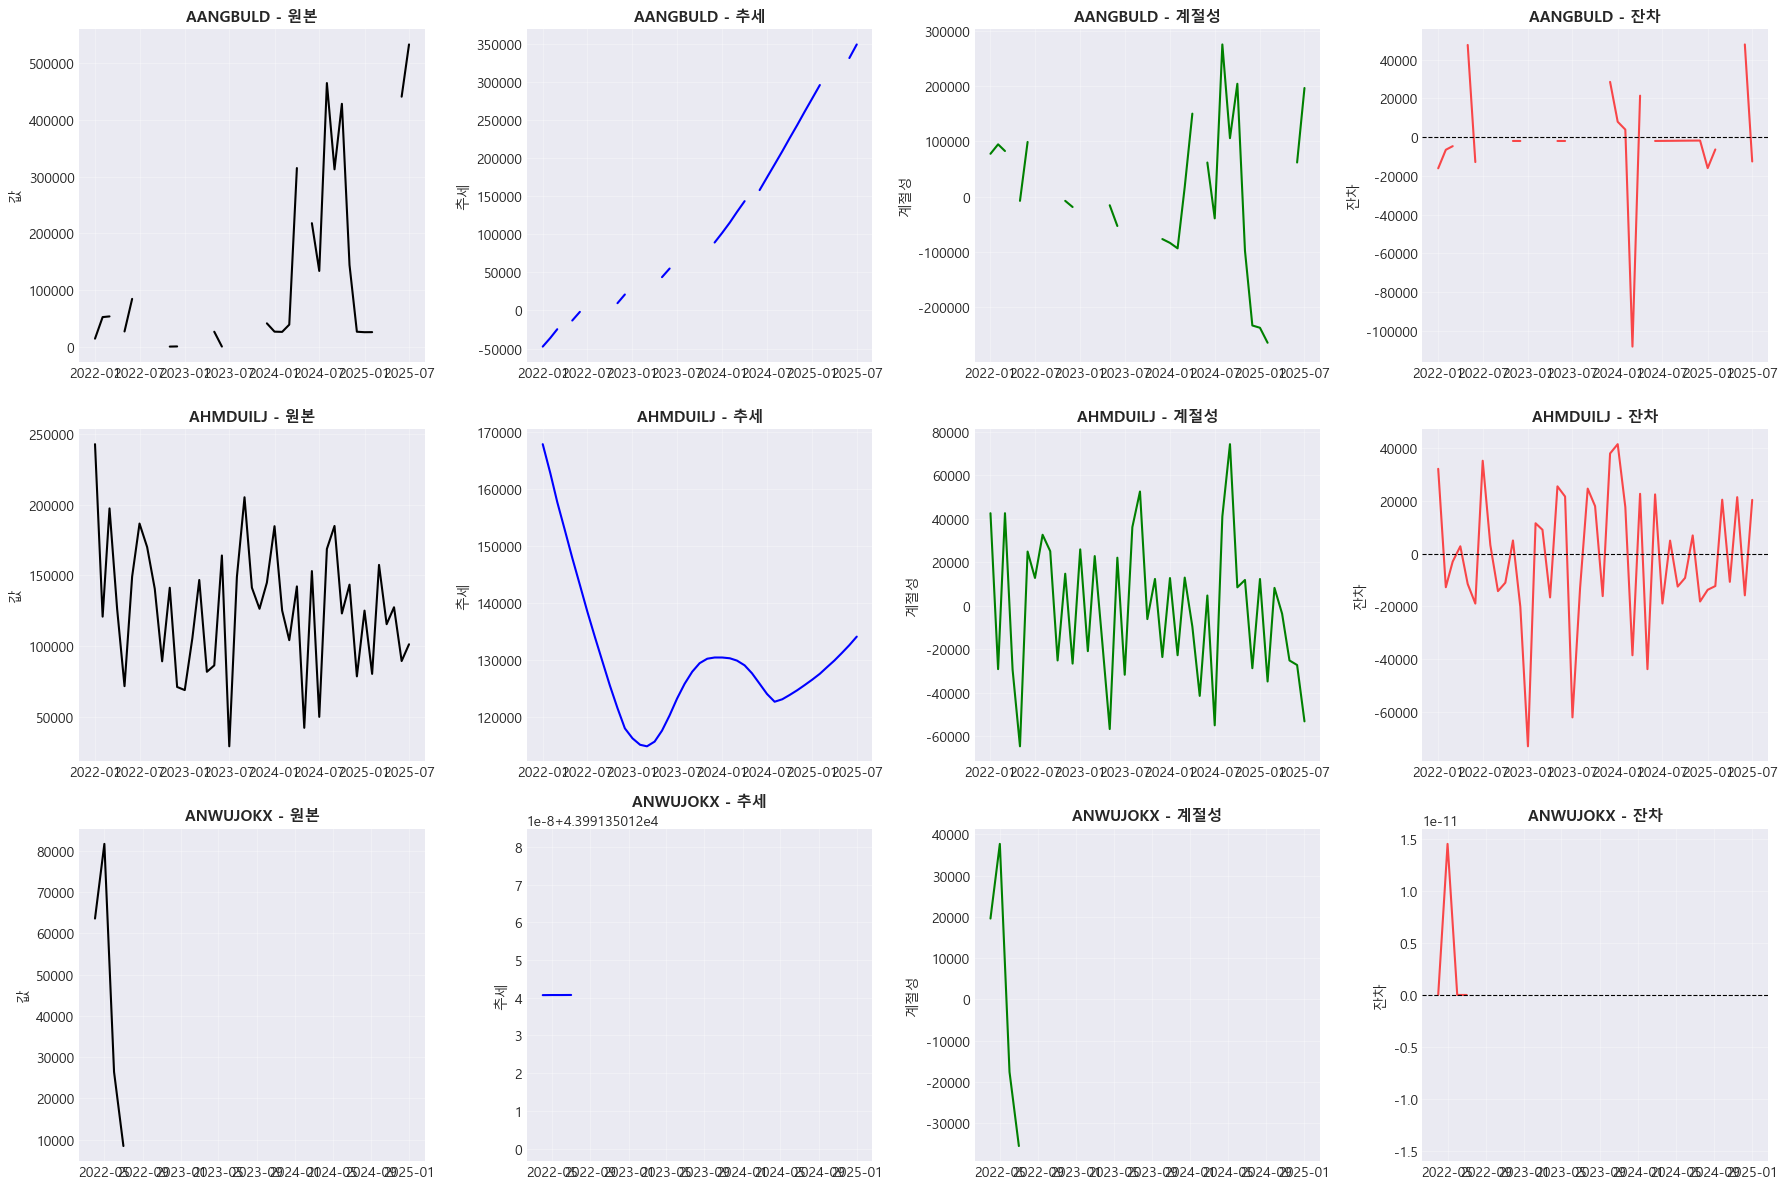

In [11]:
# 샘플 품목의 STL 분해 시각화
sample_items = df_wide.columns[:3]

fig, axes = plt.subplots(len(sample_items), 4, figsize=(18, 4*len(sample_items)))

for i, item in enumerate(sample_items):
    # 원본
    axes[i, 0].plot(df_wide.index, df_wide[item], color='black', linewidth=1.5)
    axes[i, 0].set_title(f'{item} - 원본', fontsize=11, fontweight='bold')
    axes[i, 0].set_ylabel('값')
    axes[i, 0].grid(True, alpha=0.3)
    
    # 추세
    axes[i, 1].plot(df_trend.index, df_trend[item], color='blue', linewidth=1.5)
    axes[i, 1].set_title(f'{item} - 추세', fontsize=11, fontweight='bold')
    axes[i, 1].set_ylabel('추세')
    axes[i, 1].grid(True, alpha=0.3)
    
    # 계절성
    axes[i, 2].plot(df_seasonal.index, df_seasonal[item], color='green', linewidth=1.5)
    axes[i, 2].set_title(f'{item} - 계절성', fontsize=11, fontweight='bold')
    axes[i, 2].set_ylabel('계절성')
    axes[i, 2].grid(True, alpha=0.3)
    
    # 잔차
    axes[i, 3].plot(df_resid.index, df_resid[item], color='red', linewidth=1.5, alpha=0.7)
    axes[i, 3].set_title(f'{item} - 잔차', fontsize=11, fontweight='bold')
    axes[i, 3].set_ylabel('잔차')
    axes[i, 3].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[i, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 차분 적용 (Differencing)

비정상 시계열에 1차 차분을 적용합니다.

In [12]:
# 1차 차분 적용
df_diff = df_wide.diff().dropna()

print(f"차분 후 shape: {df_diff.shape}")
print(f"제거된 행 수: {len(df_wide) - len(df_diff)}")

차분 후 shape: (0, 100)
제거된 행 수: 43


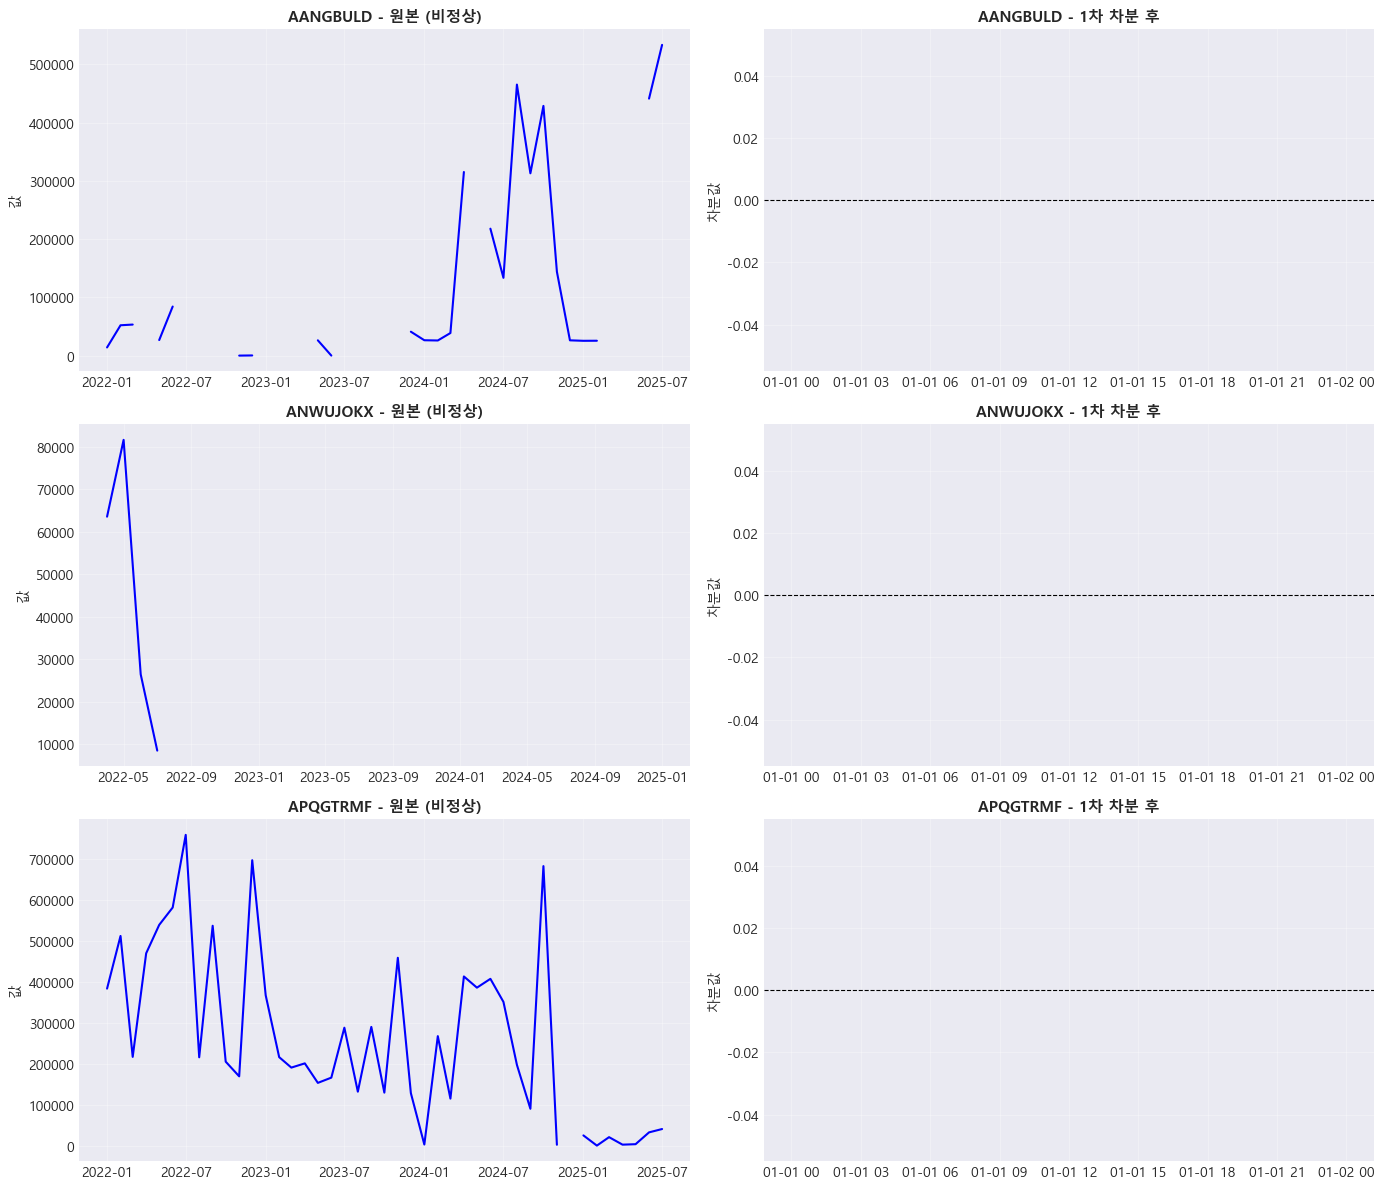

In [13]:
# 차분 전후 비교 (비정상 품목)
if len(non_stationary_items) > 0:
    sample_non_stationary = non_stationary_items[:3]
    
    fig, axes = plt.subplots(len(sample_non_stationary), 2, figsize=(14, 4*len(sample_non_stationary)))
    
    if len(sample_non_stationary) == 1:
        axes = axes.reshape(1, -1)
    
    for i, item in enumerate(sample_non_stationary):
        # 원본
        axes[i, 0].plot(df_wide.index, df_wide[item], linewidth=1.5, color='blue')
        axes[i, 0].set_title(f'{item} - 원본 (비정상)', fontsize=11, fontweight='bold')
        axes[i, 0].set_ylabel('값')
        axes[i, 0].grid(True, alpha=0.3)
        
        # 차분 후
        axes[i, 1].plot(df_diff.index, df_diff[item], linewidth=1.5, color='green')
        axes[i, 1].set_title(f'{item} - 1차 차분 후', fontsize=11, fontweight='bold')
        axes[i, 1].set_ylabel('차분값')
        axes[i, 1].axhline(0, color='black', linestyle='--', linewidth=0.8)
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("모든 품목이 정상성을 만족합니다.")

## 6. 데이터 저장

분석 결과를 저장합니다.

In [14]:
# 정상성 테스트 결과 저장
output_path = Config.DATA_PROCESSED / "stationarity_results.csv"
stationarity_results.to_csv(output_path, index=False)
print(f"✓ 정상성 테스트 결과 저장: {output_path}")

# STL 분해 결과 저장
df_trend.to_csv(Config.DATA_PROCESSED / "decomposition_trend.csv")
df_seasonal.to_csv(Config.DATA_PROCESSED / "decomposition_seasonal.csv")
df_resid.to_csv(Config.DATA_PROCESSED / "decomposition_resid.csv")
print(f"✓ STL 분해 결과 저장")

# 차분 데이터 저장
df_diff.to_csv(Config.DATA_PROCESSED / "data_differenced.csv")
print(f"✓ 차분 데이터 저장")

print("\n✓ 모든 분석 결과가 저장되었습니다!")

✓ 정상성 테스트 결과 저장: c:\Users\SMART\git\daconai\data\processed\stationarity_results.csv
✓ STL 분해 결과 저장
✓ 차분 데이터 저장

✓ 모든 분석 결과가 저장되었습니다!


In [15]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 프로젝트 루트를 경로에 추가
sys.path.insert(0, str(Path.cwd().parent))

from config import Config
from src.preprocess import (
    preprocess_pipeline,
    check_stationarity_all_items,
    decompose_all_items
)

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✓ Import 완료")

✓ Import 완료


In [16]:
# 실제 데이터 로드
data_path = Config.DATA_RAW / "train.csv"

if not data_path.exists():
    print(f"⚠️ 데이터 파일이 없습니다: {data_path}")
else:
    # 데이터 로드
    df = pd.read_csv(data_path)
    print(f"원본 데이터 shape: {df.shape}")
    
    # 날짜 생성
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    
    # 월별 집계 (SUM)
    df_agg = df.groupby(['date', 'item_id']).agg({
        'value': 'sum',
        'weight': 'sum',
        'quantity': 'sum'
    }).reset_index()
    
    # Wide 형식으로 피벗
    df_wide = df_agg.pivot(index='date', columns='item_id', values='value')
    
    print(f"✓ 전처리 완료! Wide 형식 shape: {df_wide.shape}")
    print(f"  품목 수: {len(df_wide.columns)}")

원본 데이터 shape: (10836, 9)
✓ 전처리 완료! Wide 형식 shape: (43, 100)
  품목 수: 100


In [17]:
# STL 분해 수행
decomposition_results = decompose_all_items(df_wide, period=12, seasonal=7)

df_trend = decomposition_results['trend']
df_seasonal = decomposition_results['seasonal']
df_resid = decomposition_results['resid']

print(f"Trend shape: {df_trend.shape}")
print(f"Seasonal shape: {df_seasonal.shape}")
print(f"Residual shape: {df_resid.shape}")

# 처음 3개 품목 확인
sample_items = df_wide.columns[:3]
print(f"\n샘플 품목: {list(sample_items)}")

INFO:src.preprocess:STL 분해 수행 중 (100개 품목)...
INFO:src.preprocess:✓ STL 분해 완료: 100개 품목


Trend shape: (43, 100)
Seasonal shape: (43, 100)
Residual shape: (43, 100)

샘플 품목: ['AANGBULD', 'AHMDUILJ', 'ANWUJOKX']


In [18]:
# 문제 확인: 결측치 제거 후 데이터 길이
sample_item = 'AHMDUILJ'
series = df_wide[sample_item]
print(f"품목: {sample_item}")
print(f"원본 길이: {len(series)}")
print(f"결측치 개수: {series.isna().sum()}")
print(f"dropna() 후 길이: {len(series.dropna())}")
print(f"\nSTL 요구사항: period={12}일 때 최소 {2*12+1}개 데이터 필요")
print(f"seasonal={7}이므로 실제로는 더 많은 데이터가 필요합니다.")

품목: AHMDUILJ
원본 길이: 43
결측치 개수: 0
dropna() 후 길이: 43

STL 요구사항: period=12일 때 최소 25개 데이터 필요
seasonal=7이므로 실제로는 더 많은 데이터가 필요합니다.


In [19]:
# STL 직접 실행해서 에러 확인
from statsmodels.tsa.seasonal import STL

sample_item = 'AHMDUILJ'
series = df_wide[sample_item]

print(f"Series info:")
print(f"  Length: {len(series)}")
print(f"  NaN count: {series.isna().sum()}")
print(f"  Index type: {type(series.index)}")
print(f"\nTrying STL with period=12, seasonal=7...")

try:
    stl = STL(series.dropna(), period=12, seasonal=7)
    result = stl.fit()
    print("✓ STL 성공!")
except Exception as e:
    print(f"✗ STL 실패: {e}")
    print(f"\nError type: {type(e).__name__}")

Series info:
  Length: 43
  NaN count: 0
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Trying STL with period=12, seasonal=7...
✓ STL 성공!


In [20]:
# AANGBULD를 확인 (유일하게 성공한 품목)
sample_item = 'AANGBULD'
series = df_wide[sample_item]

print(f"AANGBULD (성공한 품목):")
print(f"  Length: {len(series)}")
print(f"  NaN count: {series.isna().sum()}")
print(f"  dropna() 후 길이: {len(series.dropna())}")

# AHMDUILJ 확인 (실패한 품목)
sample_item2 = 'AHMDUILJ'
series2 = df_wide[sample_item2]

print(f"\nAHMDUILJ (실패한 품목):")
print(f"  Length: {len(series2)}")
print(f"  NaN count: {series2.isna().sum()}")
print(f"  dropna() 후 길이: {len(series2.dropna())}")

# 실제로 STL을 직접 실행해보기
try:
    stl = STL(series2.dropna(), period=12, seasonal=7)
    result = stl.fit()
    print("\n✓ AHMDUILJ STL 성공!")
except Exception as e:
    print(f"\n✗ AHMDUILJ STL 실패: {e}")

AANGBULD (성공한 품목):
  Length: 43
  NaN count: 14
  dropna() 후 길이: 29

AHMDUILJ (실패한 품목):
  Length: 43
  NaN count: 0
  dropna() 후 길이: 43

✓ AHMDUILJ STL 성공!


In [21]:
# decompose_all_items 함수를 다시 실행하되, 더 자세히 확인
import logging

# 로깅 레벨을 DEBUG로 변경
logging.getLogger('src.preprocess').setLevel(logging.DEBUG)

# 첫 5개 품목만 테스트
df_wide_sample = df_wide[df_wide.columns[:5]]

print(f"Testing STL decomposition on {len(df_wide_sample.columns)} items...")
decomposition_results = decompose_all_items(df_wide_sample, period=12, seasonal=7)

print(f"\nResults:")
print(f"  Trend shape: {decomposition_results['trend'].shape}")
print(f"  Seasonal shape: {decomposition_results['seasonal'].shape}")
print(f"  Resid shape: {decomposition_results['resid'].shape}")
print(f"\nSuccessful items: {list(decomposition_results['trend'].columns)}")

Testing STL decomposition on 5 items...


INFO:src.preprocess:STL 분해 수행 중 (5개 품목)...
INFO:src.preprocess:✓ STL 분해 완료: 5개 품목



Results:
  Trend shape: (43, 5)
  Seasonal shape: (43, 5)
  Resid shape: (43, 5)

Successful items: ['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO']


In [22]:
# decompose_stl 함수를 직접 실행해보기
from src.preprocess import decompose_stl

sample_item = 'AHMDUILJ'
series = df_wide[sample_item]

print(f"Testing decompose_stl on {sample_item}...")
print(f"  Series length: {len(series)}")
print(f"  NaN count: {series.isna().sum()}")

try:
    trend, seasonal, resid = decompose_stl(series, period=12, seasonal=7)
    print("✓ decompose_stl 성공!")
    print(f"  Trend length: {len(trend)}")
except Exception as e:
    print(f"✗ decompose_stl 실패: {e}")
    import traceback
    print("\nFull traceback:")
    traceback.print_exc()

Testing decompose_stl on AHMDUILJ...
  Series length: 43
  NaN count: 0
✓ decompose_stl 성공!
  Trend length: 43


In [23]:
# 커널 재시작 후 STL 분해 다시 시도 - 디버깅용
# decompose_all_items 내부에서 무슨 일이 일어나는지 확인

import pandas as pd
from statsmodels.tsa.seasonal import STL

# 수동으로 decompose_all_items 로직을 재현
sample_items = ['AANGBULD', 'AHMDUILJ', 'ANWUJOKX']

for item_code in sample_items:
    series = df_wide[item_code]
    print(f"\n{'='*60}")
    print(f"Item: {item_code}")
    print(f"  Original length: {len(series)}")
    print(f"  NaN count: {series.isna().sum()}")
    print(f"  After dropna: {len(series.dropna())}")
    
    try:
        series_clean = series.dropna()
        print(f"  Series clean type: {type(series_clean)}")
        print(f"  Series clean index: {series_clean.index[:5]}")
        
        stl = STL(series_clean, period=12, seasonal=7)
        result = stl.fit()
        print(f"  ✓ STL Success! Trend length: {len(result.trend)}")
    except Exception as e:
        print(f"  ✗ STL Failed: {e}")
        import traceback
        traceback.print_exc()


Item: AANGBULD
  Original length: 43
  NaN count: 14
  After dropna: 29
  Series clean type: <class 'pandas.core.series.Series'>
  Series clean index: DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-05-01',
               '2022-06-01'],
              dtype='datetime64[ns]', name='date', freq=None)
  ✓ STL Success! Trend length: 29

Item: AHMDUILJ
  Original length: 43
  NaN count: 0
  After dropna: 43
  Series clean type: <class 'pandas.core.series.Series'>
  Series clean index: DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01'],
              dtype='datetime64[ns]', name='date', freq=None)
  ✓ STL Success! Trend length: 43

Item: ANWUJOKX
  Original length: 43
  NaN count: 35
  After dropna: 8
  Series clean type: <class 'pandas.core.series.Series'>
  Series clean index: DatetimeIndex(['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-10-01'],
              dtype='datetime64[ns]', name='date', 

In [24]:
# 모듈 reload
import importlib
import src.preprocess
importlib.reload(src.preprocess)

from src.preprocess import decompose_all_items

# 다시 실행
print("Testing with reloaded module...")
decomposition_results = decompose_all_items(df_wide[df_wide.columns[:5]], period=12, seasonal=7)

print(f"\nResults:")
print(f"  Successful items: {len(decomposition_results['trend'].columns)}")
print(f"  Item names: {list(decomposition_results['trend'].columns)}")

INFO:src.preprocess:STL 분해 수행 중 (5개 품목)...
INFO:src.preprocess:✓ STL 분해 완료: 5개 품목


Testing with reloaded module...

Results:
  Successful items: 5
  Item names: ['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO']


In [25]:
# 문제 재현 - 변수명 충돌 확인
seasonal = 7
print(f"1st iteration - seasonal type: {type(seasonal)}, value: {seasonal}")

# 첫 번째 루프 시뮬레이션
from src.preprocess import decompose_stl
series = df_wide['AANGBULD']
trend, seasonal, resid = decompose_stl(series, period=12, seasonal=seasonal)

print(f"After 1st decompose_stl - seasonal type: {type(seasonal)}, length: {len(seasonal)}")

# 이제 두 번째 루프를 시뮬레이션
series2 = df_wide['AHMDUILJ']
try:
    trend, seasonal, resid = decompose_stl(series2, period=12, seasonal=seasonal)
    print("✓ 2nd iteration success")
except Exception as e:
    print(f"✗ 2nd iteration failed: {e}")

1st iteration - seasonal type: <class 'int'>, value: 7
After 1st decompose_stl - seasonal type: <class 'pandas.core.series.Series'>, length: 29
✗ 2nd iteration failed: seasonal must be an odd positive integer >= 3


In [26]:
# 모듈 reload하고 다시 테스트
import importlib
import src.preprocess
importlib.reload(src.preprocess)

from src.preprocess import decompose_all_items

# STL 분해 다시 실행 (전체 데이터)
print("STL 분해 재실행 중...")
decomposition_results = decompose_all_items(df_wide, period=12, seasonal=7)

df_trend = decomposition_results['trend']
df_seasonal = decomposition_results['seasonal']
df_resid = decomposition_results['resid']

print(f"\n✓ 성공!")
print(f"  Trend shape: {df_trend.shape}")
print(f"  Seasonal shape: {df_seasonal.shape}")
print(f"  Residual shape: {df_resid.shape}")
print(f"  성공한 품목 수: {len(df_trend.columns)}/{len(df_wide.columns)}")

STL 분해 재실행 중...

INFO:src.preprocess:STL 분해 수행 중 (100개 품목)...


INFO:src.preprocess:✓ STL 분해 완료: 100개 품목



✓ 성공!
  Trend shape: (43, 100)
  Seasonal shape: (43, 100)
  Residual shape: (43, 100)
  성공한 품목 수: 100/100


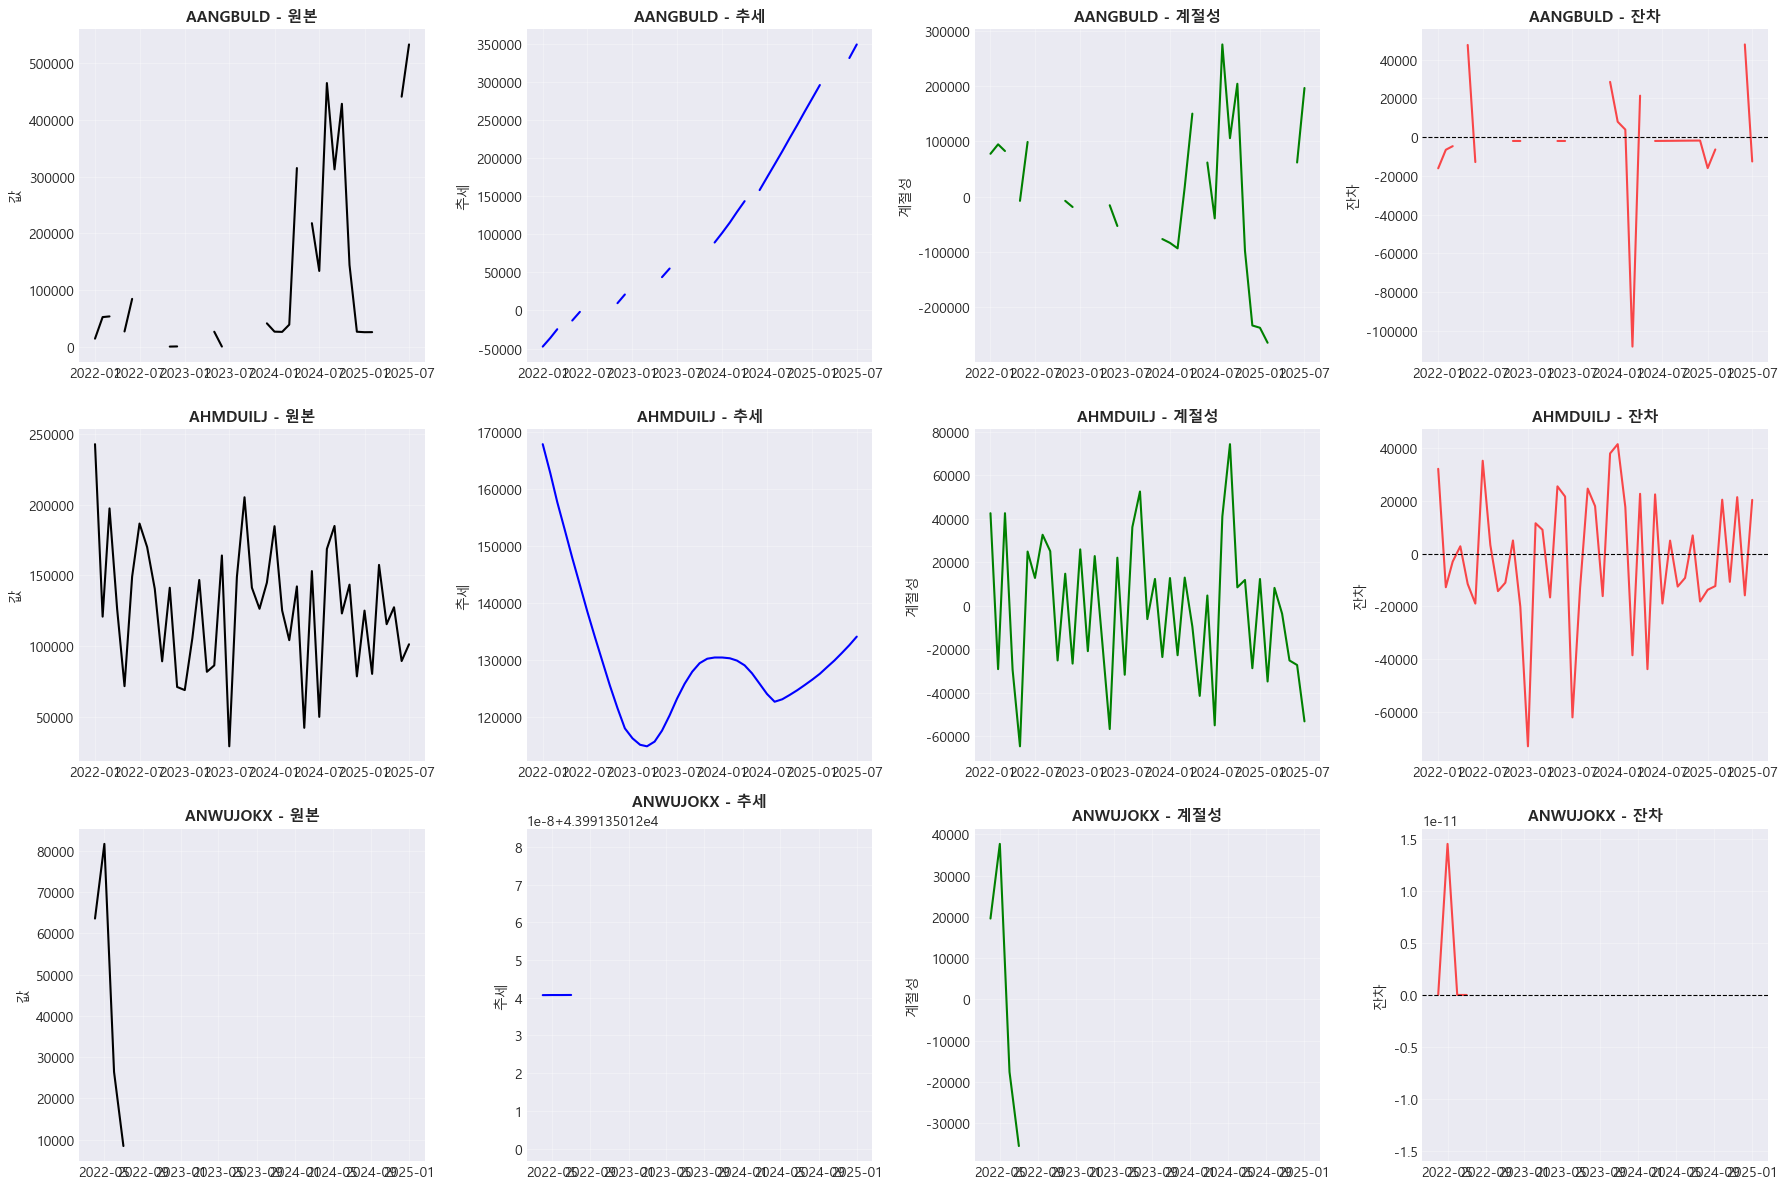


✓ 시각화 성공!


In [27]:
# 샘플 품목의 STL 분해 시각화 (노트북 cell-15와 동일한 코드)
import matplotlib.pyplot as plt

sample_items = df_wide.columns[:3]

fig, axes = plt.subplots(len(sample_items), 4, figsize=(18, 4*len(sample_items)))

for i, item in enumerate(sample_items):
    # 원본
    axes[i, 0].plot(df_wide.index, df_wide[item], color='black', linewidth=1.5)
    axes[i, 0].set_title(f'{item} - 원본', fontsize=11, fontweight='bold')
    axes[i, 0].set_ylabel('값')
    axes[i, 0].grid(True, alpha=0.3)
    
    # 추세
    axes[i, 1].plot(df_trend.index, df_trend[item], color='blue', linewidth=1.5)
    axes[i, 1].set_title(f'{item} - 추세', fontsize=11, fontweight='bold')
    axes[i, 1].set_ylabel('추세')
    axes[i, 1].grid(True, alpha=0.3)
    
    # 계절성
    axes[i, 2].plot(df_seasonal.index, df_seasonal[item], color='green', linewidth=1.5)
    axes[i, 2].set_title(f'{item} - 계절성', fontsize=11, fontweight='bold')
    axes[i, 2].set_ylabel('계절성')
    axes[i, 2].grid(True, alpha=0.3)
    
    # 잔차
    axes[i, 3].plot(df_resid.index, df_resid[item], color='red', linewidth=1.5, alpha=0.7)
    axes[i, 3].set_title(f'{item} - 잔차', fontsize=11, fontweight='bold')
    axes[i, 3].set_ylabel('잔차')
    axes[i, 3].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[i, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ 시각화 성공!")